In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas import *
from pandas_datareader import data as pdr
import tensorflow as tf
import seaborn as sns
yf.pdr_override()

In [4]:
# Tickers
tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X']

# dates
startdate = '2015-1-1'
train_end = '2017-12-31'
test_start = '2018-01-01'
enddate = '2018-12-31'

# data Close
data_close = pdr.get_data_yahoo(tickers, start=startdate, end=enddate)['Adj Close']
print('\n--- Full dataset')
display(data_close)

# data returns
data = data_close.shift(1) / data_close - 1
print('\n--- Full dataset returns')
display(data)

# Sets
data_train = data[startdate:train_end].dropna()
data_test = data[test_start:enddate].dropna()
print('\n--- Train set unadjusted')
display(data_train)
print('\n--- Test set unadjusted')
display(data_test)

# mu sigma train
mu_train = data_train.mean()
sigma_train = data_train.std()
print('\n--- mu train:')
display(pd.DataFrame(mu_train, columns=['Train set Mean']))
print('\n--- sigma train:')
display(pd.DataFrame(sigma_train, columns=['Train set st dev']))

# Final sets
data_train_prod = (data_train - mu_train) / sigma_train
data_test_prod = (data_test - mu_train) / sigma_train
print('\n--- Train set adjusted')
display(data_train_prod)
print('\n--- Test set adjusted')
display(data_test_prod)

[*********************100%***********************]  8 of 8 completed

--- Full dataset


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2015-01-01,0.77616,144.779999,1.209863,186.429993,1.558094,NaN,NaN,NaN
2015-01-02,0.77590,144.929993,1.208941,186.764999,1.557972,2058.199951,2.123,17.790001
2015-01-05,0.78148,143.860001,1.194643,184.078003,1.528491,2020.579956,2.039,19.920000
2015-01-06,0.78240,142.557007,1.193902,182.205002,1.525832,2002.609985,1.963,21.120001
2015-01-07,0.78444,140.912003,1.187536,179.625000,1.513798,2025.900024,1.954,19.309999
...,...,...,...,...,...,...,...,...
2018-12-25,0.89660,125.769997,1.140394,140.169998,1.271084,NaN,NaN,NaN
2018-12-26,0.89949,126.001999,1.141553,140.052994,1.268875,2467.699951,2.797,30.410000
2018-12-27,0.89816,126.404999,1.136131,140.695999,1.264878,2488.830078,2.743,29.959999



--- Full dataset returns


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,0.000335,-0.001035,0.000762,-0.001794,0.000078,NaN,NaN,NaN
2015-01-05,-0.007140,0.007438,0.011968,0.014597,0.019288,0.018618,0.041197,-0.106928
2015-01-06,-0.001176,0.009140,0.000621,0.010280,0.001742,0.008973,0.038716,-0.056818
2015-01-07,-0.002601,0.011674,0.005361,0.014363,0.007950,-0.011496,0.004606,0.093734
...,...,...,...,...,...,...,...,...
2018-12-25,0.002733,0.004150,-0.002729,0.002048,-0.004870,NaN,NaN,NaN
2018-12-26,-0.003213,-0.001841,-0.001015,0.000835,0.001741,NaN,NaN,NaN
2018-12-27,0.001481,-0.003188,0.004772,-0.004570,0.003159,-0.008490,0.019686,0.015020



--- Train set unadjusted


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2015-01-05,-0.007140,0.007438,0.011968,0.014597,0.019288,0.018618,0.041197,-0.106928
2015-01-06,-0.001176,0.009140,0.000621,0.010280,0.001742,0.008973,0.038716,-0.056818
2015-01-07,-0.002601,0.011674,0.005361,0.014363,0.007950,-0.011496,0.004606,0.093734
2015-01-08,0.001455,-0.001736,0.003325,-0.002986,0.002013,-0.017574,-0.030754,0.135215
2015-01-09,0.002137,-0.000623,0.003385,-0.002861,0.001299,0.008475,0.022831,-0.030769
...,...,...,...,...,...,...,...,...
2017-12-21,-0.004425,-0.005636,-0.003102,-0.001215,0.001111,-0.001982,0.006449,0.010395
2017-12-22,0.002370,0.001057,0.001758,-0.001339,-0.000628,0.000458,-0.001610,-0.028283
2017-12-27,0.000981,0.002093,0.001235,0.001050,0.000107,-0.000790,0.021955,-0.021012



--- Test set unadjusted


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2018-01-03,0.001939,0.000288,-0.004300,-0.001586,-0.006242,-0.006358,0.007356,0.067760
2018-01-04,-0.001845,0.001235,0.004415,0.002991,0.006281,-0.004012,-0.002446,-0.007592
2018-01-05,-0.001640,-0.006524,-0.004840,-0.004567,-0.003067,-0.006985,-0.009289,0.000000
2018-01-08,0.004151,-0.000595,0.002607,-0.005019,-0.001694,-0.001660,-0.001613,-0.031513
2018-01-09,0.005181,0.005678,0.005597,0.000580,0.000339,-0.001301,-0.025923,-0.055556
...,...,...,...,...,...,...,...,...
2018-12-19,0.000768,0.000461,-0.002247,-0.000316,-0.003103,0.015636,0.016919,0.000000
2018-12-20,-0.003260,-0.000187,-0.001240,0.002994,0.002151,0.016025,-0.003944,-0.098661
2018-12-21,-0.002710,0.005230,-0.005877,0.007989,-0.003308,0.021021,-0.001075,-0.057456



--- mu train:


,Train set Mean
EURGBP=X,-0.000178
EURJPY=X,0.000090
EURUSD=X,-0.000040
GBPJPY=X,0.000305
GBPUSD=X,0.000162
^GSPC,-0.000278
^TNX,-0.000102
^VIX,0.004274



--- sigma train:


,Train set st dev
EURGBP=X,0.006369
EURJPY=X,0.006734
EURUSD=X,0.006126
GBPJPY=X,0.008712
GBPUSD=X,0.006712
^GSPC,0.007816
^TNX,0.021720
^VIX,0.076458



--- Train set adjusted


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2015-01-05,-1.093199,1.091207,1.960396,1.640579,2.849289,2.417657,1.901404,-1.454415
2015-01-06,-0.156704,1.344024,0.107978,1.144988,0.235404,1.183619,1.787208,-0.799030
2015-01-07,-0.380396,1.720307,0.881667,1.613743,1.160138,-1.435322,0.216765,1.170050
2015-01-08,0.256436,-0.271073,0.549374,-0.377776,0.275753,-2.212937,-1.411214,1.712578
2015-01-09,0.363391,-0.105846,0.559180,-0.363456,0.169370,1.119871,1.055853,-0.458333
...,...,...,...,...,...,...,...,...
2017-12-21,-0.666800,-0.850231,-0.499908,-0.174502,0.141348,-0.218008,0.301620,0.080056
2017-12-22,0.400024,0.143620,0.293546,-0.188687,-0.117818,0.094188,-0.069402,-0.425814
2017-12-27,0.182006,0.297562,0.208142,0.085585,-0.008242,-0.065575,1.015529,-0.330724



--- Test set adjusted


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2018-01-03,0.332323,0.029450,-0.695440,-0.217051,-0.954163,-0.777944,0.343372,0.830332
2018-01-04,-0.261786,0.170069,0.727342,0.308306,0.911624,-0.477831,-0.107909,-0.155201
2018-01-05,-0.229555,-0.982101,-0.783588,-0.559244,-0.481116,-0.858102,-0.422970,-0.055901
2018-01-08,0.679619,-0.101651,0.432117,-0.611164,-0.276592,-0.176793,-0.069552,-0.468057
2018-01-09,0.841426,0.829883,0.920332,0.031541,0.026388,-0.130944,-1.188795,-0.782515
...,...,...,...,...,...,...,...,...
2018-12-19,0.148456,0.055117,-0.360317,-0.071280,-0.486547,2.036132,0.783642,-0.055901
2018-12-20,-0.483991,-0.041169,-0.195848,0.308682,0.296314,2.085826,-0.176879,-1.346294
2018-12-21,-0.397515,0.763300,-0.952851,0.882040,-0.517086,2.725055,-0.044765,-0.807372


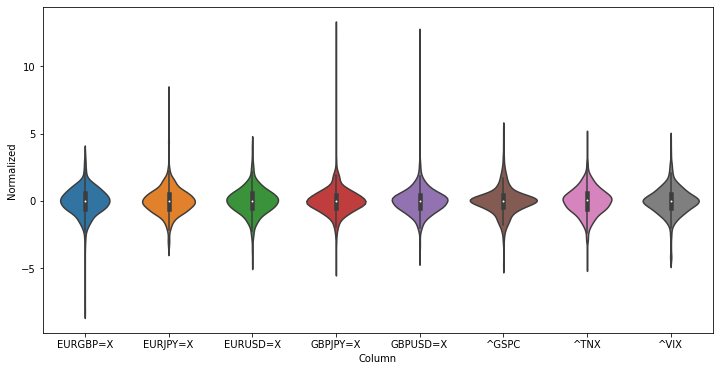

In [5]:
df_std = data_train_prod.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)

In [70]:
num_features=3
num_timesteps=1
lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

In [71]:
print(list(data_train_prod.columns))

['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X', '^GSPC', '^TNX', '^VIX']


## Index Forecasting (Conditional)

In [72]:
idx_train = data_train_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]
idx_test = data_test_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]

In [73]:
lstm_model_1.compile(loss="mae", optimizer="adam")
lstm_model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 25)                2900      
_________________________________________________________________
dropout_10 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 26        
Total params: 2,926
Trainable params: 2,926
Non-trainable params: 0
_________________________________________________________________


In [74]:
window = 1
num_features=3
inputs_1 = idx_train.values[:-window, :].reshape(-1, window, num_features)
labels_1 = idx_train.values[window:, 0]

In [75]:
lstm_model_1.fit(inputs_1, labels_1, epochs=50)

Epoch 1/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6848
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6810
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6782
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.6776
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6764
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 0.6754
Epoch 7/50
23/23 [==============================] - 0s 3ms/step - loss: 0.6758
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 0.6766
Epoch 9/50
23/23 [==============================] - 0s 3ms/step - loss: 0.6753
Epoch 10/50
23/23 [==============================] - 0s 3ms/step - loss: 0.6762
Epoch 11/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6746
Epoch 12/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6747
Epoch 13/50
23/23 [==============================

In [54]:
window = 1
num_features=3
inputs_1_test = idx_test.values[:-window, :].reshape(-1, window, num_features)
labels_1_test = idx_test.values[window:, 0]

In [55]:
lstm_model_1.evaluate(inputs_1_test, labels_1_test)

8/8 [==============================] - 0s 1ms/step - loss: 0.9178


0.9177559614181519

In [12]:
def window_data(data, window_size):
    last_index = len(data)-window_size
    
    trunc_data = [data[i:i+window_size] for i in range(last_index)]
    return np.dstack(trunc_data)
    

In [13]:
lstm_model_16.compile(loss="mae", optimizer="adam")
lstm_model_16.summary()
window = 16
num_features=3
inputs_16 = window_data(idx_train.values, window)
inputs_16 = np.transpose(inputs_16, (2, 0, 1))
labels_16 = idx_train.values[window:, 0]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                2900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 2,926
Trainable params: 2,926
Non-trainable params: 0
_________________________________________________________________


In [14]:
lstm_model_16.fit(inputs_16, labels_16, epochs=50)

Epoch 1/50
22/22 [==============================] - 0s 9ms/step - loss: 0.6751
Epoch 2/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6689
Epoch 3/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6685
Epoch 4/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6659
Epoch 5/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6622
Epoch 6/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6629
Epoch 7/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6628
Epoch 8/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6575
Epoch 9/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6614
Epoch 10/50
22/22 [==============================] - ETA: 0s - loss: 0.657 - 0s 8ms/step - loss: 0.6587
Epoch 11/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6569
Epoch 12/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6557
Epoch 13/50
22/22 [======

In [56]:
window = 16
num_features=3
inputs_16_test = window_data(idx_test.values, window)
inputs_16_test = np.transpose(inputs_16_test, (2, 0, 1))
labels_16_test = idx_test.values[window:, 0]
lstm_model_16.evaluate(inputs_16_test, labels_16_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.9875


0.9875006079673767

In [15]:
lstm_model_256.compile(loss="mae", optimizer="adam")
lstm_model_256.summary()
window = 256
num_features=3
inputs_256 = window_data(idx_train.values, window)
inputs_256 = np.transpose(inputs_256, (2, 0, 1))
labels_256 = idx_train.values[window:, 0]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 25)                2900      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 2,926
Trainable params: 2,926
Non-trainable params: 0
_________________________________________________________________


In [16]:
lstm_model_256.fit(inputs_256, labels_256, epochs=50)

Epoch 1/50
15/15 [==============================] - 1s 85ms/step - loss: 0.5292
Epoch 2/50
15/15 [==============================] - 1s 84ms/step - loss: 0.5236
Epoch 3/50
15/15 [==============================] - 1s 84ms/step - loss: 0.5221
Epoch 4/50
15/15 [==============================] - 1s 88ms/step - loss: 0.5186
Epoch 5/50
15/15 [==============================] - 1s 82ms/step - loss: 0.5185
Epoch 6/50
15/15 [==============================] - 1s 82ms/step - loss: 0.5187
Epoch 7/50
15/15 [==============================] - 1s 81ms/step - loss: 0.5211
Epoch 8/50
15/15 [==============================] - 1s 87ms/step - loss: 0.5178
Epoch 9/50
15/15 [==============================] - 1s 83ms/step - loss: 0.5163: 0s - los
Epoch 10/50
15/15 [==============================] - 1s 82ms/step - loss: 0.5121
Epoch 11/50
15/15 [==============================] - 1s 80ms/step - loss: 0.5155
Epoch 12/50
15/15 [==============================] - 1s 86ms/step - loss: 0.5140
Epoch 13/50
15/15 [========

In [58]:
# window = 256
# num_features=3
# inputs_256_test = window_data(idx_test.values, window)
# inputs_256_test = np.transpose(inputs_256_test, (2, 0, 1))
# labels_256_test = idx_test.values[window:, 0]
# lstm_model_256.evaluate(inputs_256_test, labels_256_test)

## Index Forecasting (Unconditional)

## Index Forecasting Classification (Conditional)

In [31]:
num_features=3
num_timesteps=1
class_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

num_timesteps=16
class_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

num_timesteps=256
class_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [45]:
class_lstm_model_1.compile(loss="mae", optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy()])
class_lstm_model_1.summary()
window = 1
num_features=3
inputs_1 = window_data(idx_train.values, window)
inputs_1 = np.transpose(inputs_1, (2, 0, 1))
#idx_train.values[:-window, :].reshape(-1, window, num_features)
labels_1 = idx_train.values[window:, 0] > 0
labels_1 = labels_1.astype(int)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 25)                2900      
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 2,926
Trainable params: 2,926
Non-trainable params: 0
_________________________________________________________________


In [46]:
class_lstm_model_1.fit(inputs_1, labels_1, epochs=50)

Epoch 1/50
23/23 [==============================] - 0s 2ms/step - loss: 0.4699 - binary_accuracy: 0.5495
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 0.4681 - binary_accuracy: 0.5509
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 0.4683 - binary_accuracy: 0.5523
Epoch 4/50
23/23 [==============================] - 0s 2ms/step - loss: 0.4674 - binary_accuracy: 0.5523
Epoch 5/50
23/23 [==============================] - 0s 2ms/step - loss: 0.4658 - binary_accuracy: 0.5467
Epoch 6/50
23/23 [==============================] - 0s 2ms/step - loss: 0.4652 - binary_accuracy: 0.5551
Epoch 7/50
23/23 [==============================] - 0s 3ms/step - loss: 0.4652 - binary_accuracy: 0.5495
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 0.4652 - binary_accuracy: 0.5537
Epoch 9/50
23/23 [==============================] - 0s 3ms/step - loss: 0.4645 - binary_accuracy: 0.5509
Epoch 10/50
23/23 [==============================] - 0s

In [63]:
window = 1
num_features=3
inputs_1_test = window_data(idx_test.values, window)
inputs_1_test = np.transpose(inputs_1_test, (2, 0, 1))
labels_1_test = idx_test.values[window:, 0] > 0
labels_1_test = labels_1_test.astype(int)
class_lstm_model_1.evaluate(inputs_1_test, labels_1_test)

8/8 [==============================] - 0s 2ms/step - loss: 0.5261 - binary_accuracy: 0.4661


[0.5261451005935669, 0.4661017060279846]

In [47]:
class_lstm_model_16.compile(loss="mae", optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy()])
class_lstm_model_16.summary()
window = 16
num_features=3
inputs_16 = window_data(idx_train.values, window)
inputs_16 = np.transpose(inputs_16, (2, 0, 1))
#idx_train.values[:-window, :].reshape(-1, window, num_features)
labels_16 = idx_train.values[window:, 0] > 0
labels_16 = labels_16.astype(int)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 25)                2900      
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 26        
Total params: 2,926
Trainable params: 2,926
Non-trainable params: 0
_________________________________________________________________


In [49]:
class_lstm_model_16.fit(inputs_16, labels_16, epochs=50)

Epoch 1/50
22/22 [==============================] - 0s 9ms/step - loss: 0.3852 - binary_accuracy: 0.6211
Epoch 2/50
22/22 [==============================] - 0s 8ms/step - loss: 0.3766 - binary_accuracy: 0.6296
Epoch 3/50
22/22 [==============================] - 0s 8ms/step - loss: 0.3760 - binary_accuracy: 0.6325
Epoch 4/50
22/22 [==============================] - 0s 8ms/step - loss: 0.3718 - binary_accuracy: 0.6368
Epoch 5/50
22/22 [==============================] - 0s 8ms/step - loss: 0.3682 - binary_accuracy: 0.6467
Epoch 6/50
22/22 [==============================] - 0s 8ms/step - loss: 0.3701 - binary_accuracy: 0.6368
Epoch 7/50
22/22 [==============================] - 0s 8ms/step - loss: 0.3712 - binary_accuracy: 0.6368A: 0s - loss: 0.3712 - binary_accuracy: 0.636
Epoch 8/50
22/22 [==============================] - 0s 9ms/step - loss: 0.3686 - binary_accuracy: 0.6353
Epoch 9/50
22/22 [==============================] - 0s 8ms/step - loss: 0.3670 - binary_accuracy: 0.6382
Epoch 10/5

In [64]:
window = 16
num_features=3
inputs_16_test = window_data(idx_test.values, window)
inputs_16_test = np.transpose(inputs_16_test, (2, 0, 1))
labels_16_test = idx_test.values[window:, 0] > 0
labels_16_test = labels_16_test.astype(int)
class_lstm_model_16.evaluate(inputs_16_test, labels_16_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.4846 - binary_accuracy: 0.5158


[0.484597772359848, 0.5158371329307556]

In [48]:
class_lstm_model_256.compile(loss="mae", optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy()])
class_lstm_model_256.summary()
window = 256
num_features=3
inputs_256 = window_data(idx_train.values, window)
inputs_256 = np.transpose(inputs_256, (2, 0, 1))
#idx_train.values[:-window, :].reshape(-1, window, num_features)
labels_256 = idx_train.values[window:, 0] > 0
labels_256 = labels_256.astype(int)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 25)                2900      
_________________________________________________________________
dropout_9 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 2,926
Trainable params: 2,926
Non-trainable params: 0
_________________________________________________________________


In [50]:
class_lstm_model_256.fit(inputs_256, labels_256, epochs=50)

Epoch 1/50
15/15 [==============================] - 1s 91ms/step - loss: 0.3633 - binary_accuracy: 0.6450: 0s - loss: 0.3677 - binary_accuracy: 0.
Epoch 2/50
15/15 [==============================] - 1s 89ms/step - loss: 0.3447 - binary_accuracy: 0.6905
Epoch 3/50
15/15 [==============================] - 1s 85ms/step - loss: 0.3495 - binary_accuracy: 0.6775
Epoch 4/50
15/15 [==============================] - 1s 85ms/step - loss: 0.3493 - binary_accuracy: 0.6840
Epoch 5/50
15/15 [==============================] - 1s 88ms/step - loss: 0.3499 - binary_accuracy: 0.6775
Epoch 6/50
15/15 [==============================] - 1s 85ms/step - loss: 0.3559 - binary_accuracy: 0.6623
Epoch 7/50
15/15 [==============================] - 1s 87ms/step - loss: 0.3482 - binary_accuracy: 0.6688
Epoch 8/50
15/15 [==============================] - 1s 95ms/step - loss: 0.3589 - binary_accuracy: 0.6515
Epoch 9/50
15/15 [==============================] - 1s 96ms/step - loss: 0.3407 - binary_accuracy: 0.6861
Epoch

## Index Forecasting Classification (Unconditional)

## Exchange Rate Forecasting (Conditional)

In [21]:
num_features=5
num_timesteps=1
er_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
er_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
er_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

In [65]:
er_columns = ['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X']
er_train = data_train_prod.loc[:, er_columns]
er_test = data_test_prod.loc[:, er_columns]

In [24]:
for i in range(5):
    print(er_columns[i])
    er_lstm_model_1.compile(loss="mae", optimizer="adam")
    window = 1
    num_features=5
    inputs_1 = er_train.values[:-window, :].reshape(-1, window, num_features)
    labels_1 = er_train.values[window:, i]
    er_lstm_model_1.fit(inputs_1, labels_1, epochs=50)

EURGBP=X
Epoch 1/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7484
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7466
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7478
Epoch 4/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7440
Epoch 5/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7455
Epoch 6/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7416
Epoch 7/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7412
Epoch 8/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7424
Epoch 9/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7426
Epoch 10/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7440
Epoch 11/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7427
Epoch 12/50
23/23 [==============================] - 0s 2ms/step - loss: 0.7431
Epoch 13/50
23/23 [=====================

In [69]:
window = 1
num_features=5
er_inputs_1_test = window_data(er_test.values, window)
er_inputs_1_test = np.transpose(er_inputs_1_test, (2, 0, 1))
er_labels_1_test = er_test.values[window:, 0] > 0
er_labels_1_test = er_labels_1_test.astype(int)
er_lstm_model_1.evaluate(er_inputs_1_test, er_labels_1_test)

8/8 [==============================] - 0s 1ms/step - loss: 0.5336


0.5336290001869202

In [26]:
for i in range(5):
    print(er_columns[i])
    er_lstm_model_16.compile(loss="mae", optimizer="adam")
    window = 16
    num_features=5
    inputs_16 = window_data(er_train.values, window)
    inputs_16 = np.transpose(inputs_16, (2, 0, 1))
    labels_16 = er_train.values[window:, i]
    er_lstm_model_16.fit(inputs_16, labels_16, epochs=50)

EURGBP=X
Epoch 1/50
22/22 [==============================] - 0s 7ms/step - loss: 0.6797
Epoch 2/50
22/22 [==============================] - 0s 6ms/step - loss: 0.6734
Epoch 3/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6676
Epoch 4/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6674
Epoch 5/50
22/22 [==============================] - 0s 7ms/step - loss: 0.6623
Epoch 6/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6642
Epoch 7/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6659
Epoch 8/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6640
Epoch 9/50
22/22 [==============================] - 0s 7ms/step - loss: 0.6643
Epoch 10/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6637
Epoch 11/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6615
Epoch 12/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6625
Epoch 13/50
22/22 [=====================

In [29]:
for i in range(5):
    print(er_columns[i])
    er_lstm_model_256.compile(loss="mae", optimizer="adam")
    window = 256
    num_features=5
    inputs_256 = window_data(er_train.values, window)
    inputs_256 = np.transpose(inputs_256, (2, 0, 1))
    labels_256 = er_train.values[window:, i]
    er_lstm_model_256.fit(inputs_256, labels_256, epochs=50)

EURGBP=X
Epoch 1/50
15/15 [==============================] - 1s 85ms/step - loss: 0.9249
Epoch 2/50
15/15 [==============================] - 1s 87ms/step - loss: 0.8334
Epoch 3/50
15/15 [==============================] - 1s 84ms/step - loss: 0.8017: 0s - loss: 0.
Epoch 4/50
15/15 [==============================] - 1s 82ms/step - loss: 0.7861
Epoch 5/50
15/15 [==============================] - 1s 84ms/step - loss: 0.7845
Epoch 6/50
15/15 [==============================] - 1s 83ms/step - loss: 0.7742
Epoch 7/50
15/15 [==============================] - 1s 87ms/step - loss: 0.7706
Epoch 8/50
15/15 [==============================] - 1s 87ms/step - loss: 0.7730
Epoch 9/50
15/15 [==============================] - 1s 90ms/step - loss: 0.7608
Epoch 10/50
15/15 [==============================] - 2s 101ms/step - loss: 0.7691
Epoch 11/50
15/15 [==============================] - 2s 100ms/step - loss: 0.7504
Epoch 12/50
15/15 [==============================] - 1s 97ms/step - loss: 0.7587
Epoch 13/50